In [1]:
from scipy.io import loadmat
from scipy.io import savemat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys

import random
from tqdm import tqdm

In [2]:
if "google.colab" in sys.modules:
    root_dir = os.path.join(
        os.getcwd(), "drive", "MyDrive", "Colab Notebooks"
    )
    data_dir = os.path.join(root_dir, "data")
else:
    root_dir = os.getcwd()
    data_dir = os.path.join(root_dir, "data")

In [3]:
dir = os.path.join(data_dir, "SPST_perfect")

In [4]:
file = loadmat(os.path.join(dir, "SPSTdata_2_pol-60.mat"))

In [5]:
maps = file["AcombineAll"][0]
azimuts = file["Fa_real"][0]
elevations = file["Fb_real"][0]
nom_intensities = file["Max4"][0]
X = file["Xnom_dumARRAY"][0]
Y = file["Ynom_dumARRAY"][0]
df = pd.DataFrame(
    {
        "map": maps,
        "azimut": azimuts,
        "elevation": elevations,
        "nom_intensity": nom_intensities,
        "X": X,
        "Y": Y,
    }
)

In [153]:
def get_index(X, Y, x, y):
    for i in range(len(X)):
        if X[i] == x and Y[i] == y:
            return i
    return -1

def get_neighbours(map, x, y):
    neighbours = []
    if x > 0:
        neighbours.append((x - 1, y))
    if x < len(map) - 1:
        neighbours.append((x + 1, y))
    if y > 0:
        neighbours.append((x, y - 1))
    if y < len(map) - 1:
        neighbours.append((x, y + 1))
    neighbours = [n for n in neighbours if not np.isnan(map[n[0]][n[1]])]
    return neighbours

def get_map(i, j, forbidden, len_map, maps, coords):
    values = [maps[l][i][j] for l in range(len(maps)) if l not in forbidden]
                
    map = np.empty((len_map, len_map))
    for x in range(len_map):
        for y in range(len_map):
            x_real = x * 20 + 7
            y_real = y * 20 + 7

            if (x_real, y_real) in coords:
                index = coords[(x_real, y_real)]
                map[x][y] = values[index]
            elif (x_real + 1, y_real) in coords:
                index = coords[(x_real + 1, y_real)]
                map[x][y] = values[index]
            elif (x_real - 1, y_real) in coords:
                index = coords[(x_real - 1, y_real)]
                map[x][y] = values[index]
            elif (x_real, y_real + 1) in coords:
                index = coords[(x_real, y_real + 1)]
                map[x][y] = values[index]
            elif (x_real, y_real - 1) in coords:
                index = coords[(x_real, y_real - 1)]
                map[x][y] = values[index]
            elif (x_real + 1, y_real + 1) in coords:
                index = coords[(x_real + 1, y_real + 1)]
                map[x][y] = values[index]
            elif (x_real - 1, y_real - 1) in coords:
                index = coords[(x_real - 1, y_real - 1)]
                map[x][y] = values[index]
            elif (x_real + 1, y_real - 1) in coords:
                index = coords[(x_real + 1, y_real - 1)]
                map[x][y] = values[index]
            elif (x_real - 1, y_real + 1) in coords:
                index = coords[(x_real - 1, y_real + 1)]
                map[x][y] = values[index]
            else:
                map[x][y] = np.nan
    return map

def get_map_coords(len_map, coords):
    map_coords = np.zeros((len_map, len_map), dtype=object)
    for x in range(len_map):
        for y in range(len_map):
            x_real = x * 20 + 7
            y_real = y * 20 + 7

            if (x_real, y_real) in coords:
                map_coords[x][y] = (x_real, y_real)
            elif (x_real + 1, y_real) in coords:
                map_coords[x][y] = (x_real + 1, y_real)
            elif (x_real - 1, y_real) in coords:
                map_coords[x][y] = (x_real - 1, y_real)
            elif (x_real, y_real + 1) in coords:
                map_coords[x][y] = (x_real, y_real + 1)
            elif (x_real, y_real - 1) in coords:
                map_coords[x][y] = (x_real, y_real - 1)
            elif (x_real + 1, y_real + 1) in coords:
                map_coords[x][y] = (x_real + 1, y_real + 1)
            elif (x_real - 1, y_real - 1) in coords:
                map_coords[x][y] = (x_real - 1, y_real - 1)
            elif (x_real + 1, y_real - 1) in coords:
                map_coords[x][y] = (x_real + 1, y_real - 1)
            elif (x_real - 1, y_real + 1) in coords:
                map_coords[x][y] = (x_real - 1, y_real + 1)
            else:
                map_coords[x][y] = (x_real, y_real)
    return map_coords

def densify_to(map, target_grid):
    len_map = len(map)

    map2 = np.ones((target_grid, target_grid)) * np.nan
    for x in range(len_map):
        for y in range(len_map):
            x_ind = int(x * target_grid / len_map)
            y_ind = int(y * target_grid / len_map)
            map2[x_ind][y_ind] = map[x][y]
    
    while np.isnan(map2).any():
        map2_copy = map2.copy()
        for x in range(len(map2_copy)):
            for y in range(len(map2_copy)):
                if np.isnan(map2_copy[x][y]):
                    neighbours = get_neighbours(map2_copy, x, y)
                    if len(neighbours) > 0:
                        map2[x][y] = np.mean([map2_copy[n[0]][n[1]] for n in neighbours])
    return map2

# reverse the map to the original size
def rev_densify_to(map, target_grid):
    len_map = len(map)

    map2 = np.ones((target_grid, target_grid))
    for x in range(target_grid):
        for y in range(target_grid):
            x_ind = int(x * len_map / target_grid)
            y_ind = int(y * len_map / target_grid)
            map2[x][y] = map[x_ind][y_ind]
    return map2

In [23]:
len_map = 26

forbiden = [196, 197, 216, 217, 236, 237, 251, 255, 256, 262, 276, 277, 297, 317]
ind_forbiden = []

coords = []
for l in range(len(df)):
    # ignore the additional values in the center
    if df["X"][l] not in forbiden and df["Y"][l] not in forbiden:
        coords.append((df["X"][l], df["Y"][l]))
    else:
        ind_forbiden.append(l)
coords_dict = {coord: index for index, coord in enumerate(coords)}

# Number of iterations for your loop
len_map_big = len(df["map"][0])
total_tasks = len_map_big * len_map_big

maps = np.zeros((total_tasks, len_map, len_map))

nom_coords = [(i, j) for i in range(len_map_big) for j in range(len_map_big)]

map_coords = get_map_coords(len_map, coords)
map_coords = map_coords.T
map_coords = map_coords[::-1]

# Initialize the progress bars
progress_bar = tqdm(desc='Process', total=total_tasks, unit='task', dynamic_ncols=True)

map_list = df["map"].tolist()

print("Overhead done, starting the loop", flush=True)

ind = 0
for i in range(len_map_big):
    for j in range(len_map_big):
        map = get_map(i, j, ind_forbiden, len_map, map_list, coords_dict)
        # transpose the maps
        map = map.T
        #reverse the y axis
        map = map[::-1]

        maps[ind] = map
        ind += 1
        progress_bar.update(1)

# Close the progress bar
progress_bar.close()

Process:   0%|          | 0/262144 [00:00<?, ?task/s]

Overhead done, starting the loop


Process: 100%|██████████| 262144/262144 [40:30<00:00, 107.85task/s]


In [ ]:
ind = random.randint(0, len(maps))
map = maps[ind]
map2 = densify_map(map)

# plot the map
plt.imshow(map, cmap="jet")
plt.colorbar()
plt.show()

# plot the map
plt.imshow(map2, cmap="jet")
plt.colorbar()
plt.show()

plt.scatter(
    [map_coords[x][y][0] for x in range(len(map_coords)) for y in range(len(map_coords))],
    [map_coords[x][y][1] for x in range(len(map_coords)) for y in range(len(map_coords))],
    c=[map[x][y] for x in range(len(map)) for y in range(len(map))],
    cmap="jet",
    s=100,
    marker="s",
)
plt.colorbar()
plt.show()

In [32]:
dict = {
    "maps": maps,
    "map_coords": map_coords,
    "forbiden": forbiden,
    "coords_dict": coords_dict,
    "nom_coords": nom_coords,
}
savemat(os.path.join(dir, "FPSTdata_2_pol-60.mat"), dict)

In [35]:
file = loadmat(os.path.join(dir, "FPSTdata_2_pol-60.mat"))

maps = file["maps"]
map_coords = file["map_coords"]
forbiden = file["forbiden"][0]
coords_dict = file["coords_dict"]
nom_coords = file["nom_coords"]

0.0


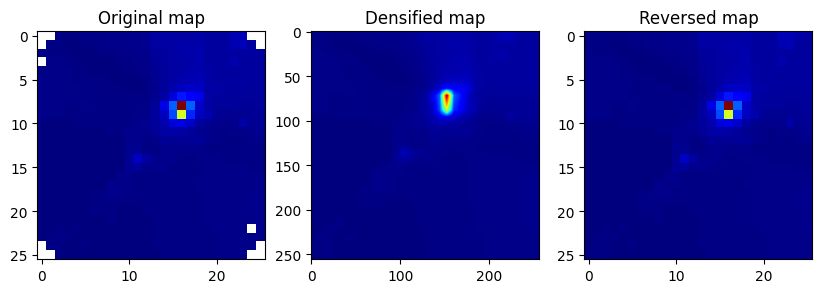

In [160]:
ind = random.randint(0, len(maps))
map = maps[ind]

#map2 = densify_to(map, 26 * 2)

map2 = densify_to(map, 32)
map2 = densify_to(map2, 64)
map2 = densify_to(map2, 128)
map2 = densify_to(map2, 256)

map3 = rev_densify_to(map2, 128)
map3 = rev_densify_to(map3, 64)
map3 = rev_densify_to(map3, 32)
map3 = rev_densify_to(map3, 26)

# compute the difference between the two maps
diff = np.sum(np.abs(map - map3), where=~np.isnan(map))
print(diff)

# plot the maps
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(map, cmap="jet")
axs[0].set_title("Original map")
axs[1].imshow(map2, cmap="jet")
axs[1].set_title("Densified map")
axs[2].imshow(map3, cmap="jet")
axs[2].set_title("Reversed map")
plt.show()